El objetivo de este notebook es comparar los modelos base implementados en el notebook 03.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import sys
from pathlib import Path
from collections import Counter

# Añadir directorio raíz al path
sys.path.append(str(Path().resolve().parent))

from src.config import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE, TEST_SIZE, TARGET_COLUMN

# --- Carga y limpieza de datos para comparación de modelos avanzados ---
df = pd.read_csv(PROCESSED_DATA_DIR / "startup_data_processed.csv")

prefijos_a_eliminar = [
    'closed', 'name', 'city', 'id', 'object', 'last', 'first', 'zip', 'Unnamed:', 'founded'
]
cols_problematicas = [col for col in df.columns if any(col.startswith(pref) for pref in prefijos_a_eliminar)]
df = df.drop(columns=cols_problematicas)

columnas_a_eliminar = [
    'Unnamed: 0', 'id', 'object_id', 'Unnamed: 6', 'state_code.1',
    'zip_code', 'city', 'name', 'closed_at',
    'founded_at', 'first_funding_at', 'last_funding_at', 'labels'
]
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

cols_baja_var = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=cols_baja_var)

X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

print(f"Tamaño del conjunto de entrenamiento: {X.shape}")
print("Distribución del target:")
print(y.value_counts(normalize=True))
print("¿Hay valores nulos en X?:", X.isnull().any().any())
print("¿Hay valores nulos en y?:", y.isnull().any())
display(df.head())

Tamaño del conjunto de entrenamiento: (923, 135)
Distribución del target:
status
acquired    0.646804
closed      0.353196
Name: proportion, dtype: float64
¿Hay valores nulos en X?: False
¿Hay valores nulos en y?: False


,latitude,longitude,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,...,category_code_real_estate,category_code_search,category_code_security,category_code_semiconductor,category_code_social,category_code_software,category_code_sports,category_code_transportation,category_code_travel,category_code_web
0,1.027268,1.451271,0.005448,-0.313102,0.623990,0.679721,-0.648696,0.495665,-0.132140,0.876138,...,False,False,False,False,False,False,False,False,False,False
1,-0.341900,-0.823630,1.151960,2.044918,1.481175,0.782391,0.177541,1.215002,0.077455,-0.636819,...,False,False,False,False,False,False,False,False,False,False
2,-1.501922,-0.610018,-0.479349,-0.977162,-0.553767,-0.852690,-0.373284,-0.943010,-0.120401,0.119660,...,False,False,False,False,False,False,False,False,False,True
3,-0.320134,-0.827040,0.357050,0.466454,1.113359,0.440795,-0.373284,0.495665,0.076928,-0.636819,...,False,False,False,False,False,True,False,False,False,False
4,-0.197397,-0.843535,-0.891013,-0.762888,-1.074277,-1.590895,-0.786402,-0.223673,-0.127260,-0.636819,...,False,False,False,False,False,False,False,False,False,False


Definimos modelos avanzados para la comparativa

In [2]:
# --- Definición de modelos avanzados: Random Forest y XGBoost ---

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Definir el modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Definir el modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Modelos avanzados definidos: Random Forest y XGBoost")

Modelos avanzados definidos: Random Forest y XGBoost


Añadimos la búsqueda de hiperparámetros para los modelos Random Forest y XGBoost. De esta forma optimizamos los parámetros para mejorar el rendimiento ya que es el proceso para encontrar la mejor combinación de parámetros para un modelo dado.

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print([col for col in X.columns if 'status' in col or 'acquired' in col or 'closed' in col or 'id' in col])
print([col for col in X.columns if X[col].nunique() == len(X)])

cols_muchos_unicos = [col for col in X.columns if X[col].nunique() > 0.9 * len(X)]
print("Columnas con muchos valores únicos:", cols_muchos_unicos)

for col in X.columns:
    if X[col].nunique() > 1:
        corr = np.corrcoef(X[col], y_encoded)[0, 1]
        if abs(corr) > 0.99:
            print(f"Columna {col} tiene correlación perfecta con el target: {corr}")

print([col for col in X.columns if X[col].nunique() <= 1])

['is_gamesvideo', 'category_code_games_video', 'category_code_photo_video']
[]
Columnas con muchos valores únicos: []
[]


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib



# --- Definir grids de hiperparámetros ---
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# --- Búsqueda de hiperparámetros con GridSearchCV ---

# Random Forest
print("Buscando mejores hiperparámetros para Random Forest...")
rf_grid = GridSearchCV(
    rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)
rf_grid.fit(X, y_encoded)
print("Mejor configuración RF:", rf_grid.best_params_)
print("Mejor accuracy (CV):", rf_grid.best_score_)
joblib.dump(rf_grid.best_estimator_, MODELS_DIR / "best_rf_model.pkl")

# XGBoost
print("Buscando mejores hiperparámetros para XGBoost...")
xgb_grid = GridSearchCV(
    xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)
xgb_grid.fit(X, y_encoded)
print("Mejor configuración XGB:", xgb_grid.best_params_)
print("Mejor accuracy (CV):", xgb_grid.best_score_)
joblib.dump(xgb_grid.best_estimator_, MODELS_DIR / "best_xgb_model.pkl")

Buscando mejores hiperparámetros para Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejor configuración RF: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor accuracy (CV): 0.7995417156286722
Buscando mejores hiperparámetros para XGBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejor configuración XGB: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mejor accuracy (CV): 0.7984841363102233


c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['C:\\Users\\alexl\\OneDrive\\Escritorio\\Machine Learning\\startups-ml\\models\\best_xgb_model.pkl']

Evaluación de los modelos ganadores


--- Evaluación de Random Forest en test ---
Accuracy en test: 0.9027
Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.88      0.99      0.93       120
      closed       0.98      0.74      0.84        65

    accuracy                           0.90       185
   macro avg       0.93      0.87      0.89       185
weighted avg       0.91      0.90      0.90       185



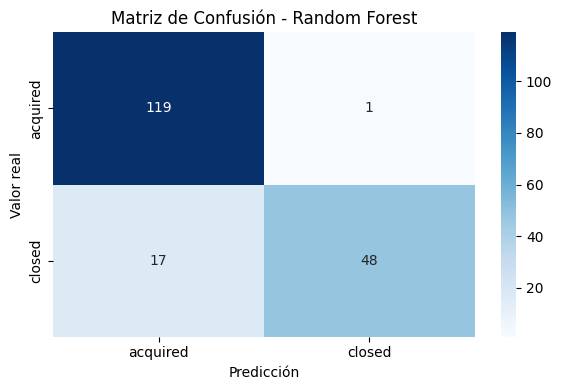


--- Evaluación de XGBoost en test ---
Accuracy en test: 0.8757
Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.88      0.94      0.91       120
      closed       0.88      0.75      0.81        65

    accuracy                           0.88       185
   macro avg       0.88      0.85      0.86       185
weighted avg       0.88      0.88      0.87       185



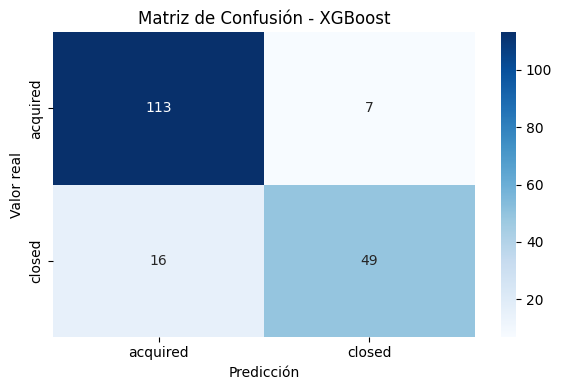

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#Realiza el split ahora:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

# Cargar los mejores modelos entrenados
best_rf = joblib.load(MODELS_DIR / "best_rf_model.pkl")
best_xgb = joblib.load(MODELS_DIR / "best_xgb_model.pkl")

# Evaluar en test
for model, name in zip([best_rf, best_xgb], ["Random Forest", "XGBoost"]):
    print(f"\n--- Evaluación de {name} en test ---")
    y_pred = model.predict(X_test)
    print(f"Accuracy en test: {accuracy_score(y_test, y_pred):.4f}")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Matriz de confusión
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.title(f'Matriz de Confusión - {name}')
    plt.tight_layout()
    plt.savefig(f"../reports/figures/model_comparison/confusion_matrix_{name}.png")
    plt.show()

Interpretabilidad y análisis de importancia de variables

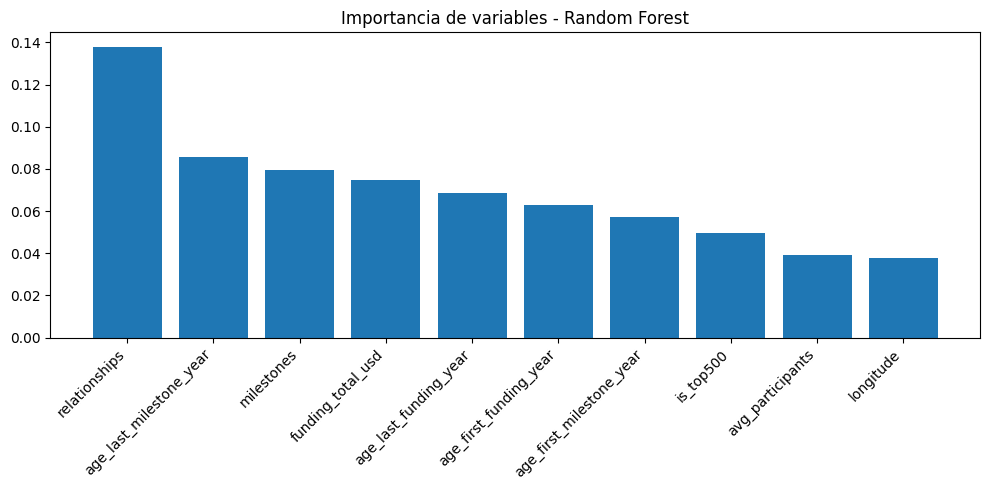

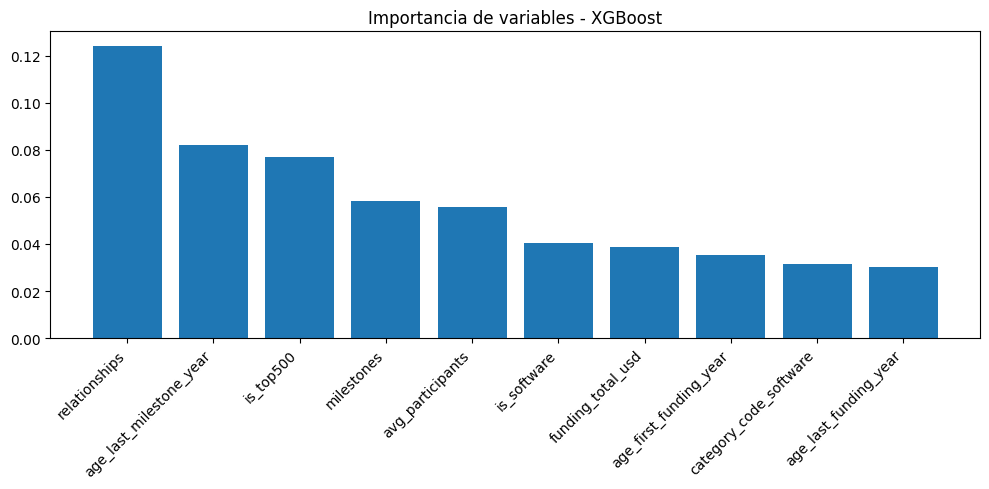

In [6]:
import matplotlib.pyplot as plt
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
features_rf = X.columns[indices_rf]

plt.figure(figsize=(10, 5))
plt.title("Importancia de variables - Random Forest")
plt.bar(range(10), importances_rf[indices_rf][:10], align="center")
plt.xticks(range(10), features_rf[:10], rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"../reports/figures/model_comparison/feature_importance_rf.png")
plt.show()

importances_xgb = best_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
features_xgb = X.columns[indices_xgb]

plt.figure(figsize=(10, 5))
plt.title("Importancia de variables - XGBoost")
plt.bar(range(10), importances_xgb[indices_xgb][:10], align="center")
plt.xticks(range(10), features_xgb[:10], rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"../reports/figures/model_comparison/feature_importance_xgb.png")
plt.show()

Interpretabilidad con SHAP

<Figure size 640x480 with 0 Axes>

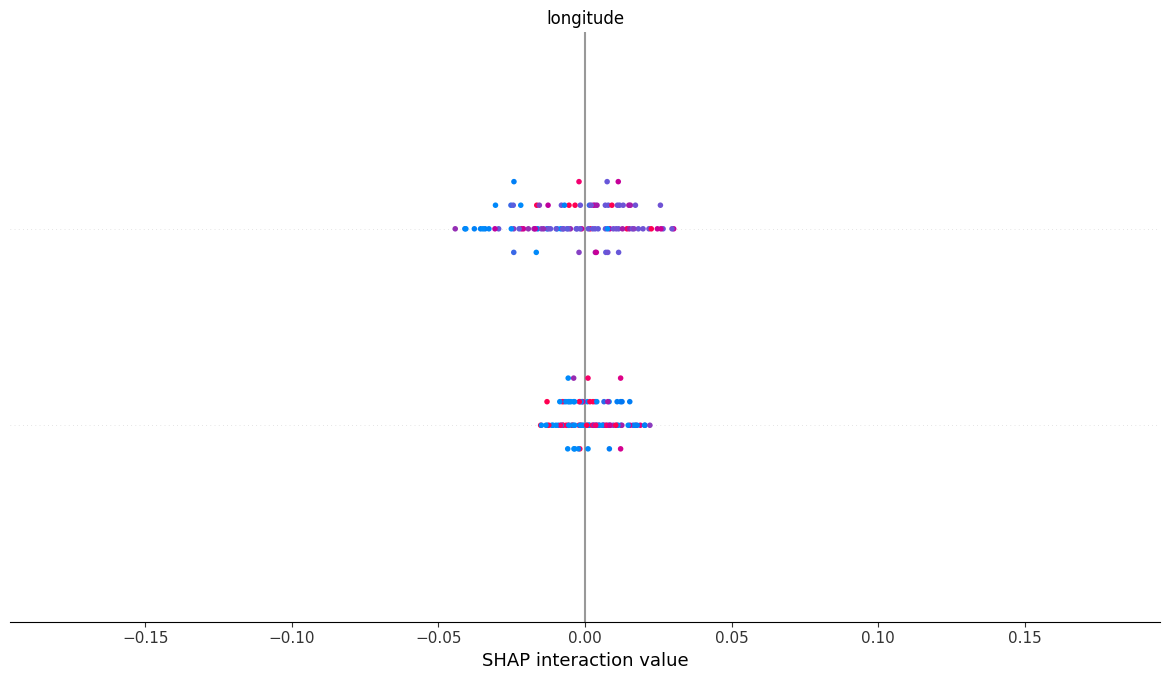

In [ ]:
import shap

explainer_rf = shap.TreeExplainer(best_rf, feature_perturbation="tree_path_dependent")
shap_values_rf = explainer_rf.shap_values(X_test.iloc[:100])
shap.summary_plot(shap_values_rf, X_test.iloc[:100], feature_names=X_test.columns, show=True)


> **Nota:** Aunque el modelo Random Forest utiliza múltiples variables relevantes (como se observa en `feature_importances_`), la visualización SHAP solo resalta `longitude`. Esto es un comportamiento conocido y documentado en ciertas versiones de SHAP con RandomForestClassifier de scikit-learn.  
> Para interpretabilidad fiable, se recomienda consultar tanto SHAP (cuando sea posible) como las importancias estándar del modelo.

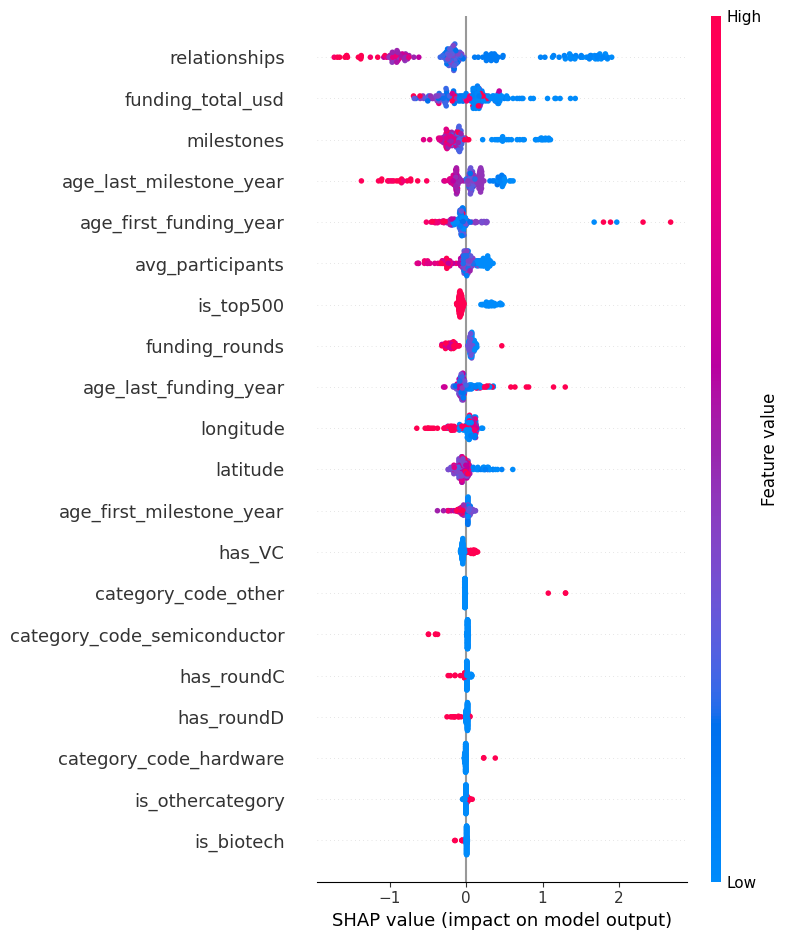

In [8]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

if isinstance(shap_values_xgb, list):
    shap.summary_plot(shap_values_xgb[1], X_test, feature_names=X_test.columns, show=True)
else:
    shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns, show=True)

## Comparación de Modelos: Random Forest vs XGBoost

A continuación se resumen las diferencias clave observadas entre los dos modelos entrenados:

| Aspecto                        | Random Forest                         | XGBoost                              |
|---------------------------------|---------------------------------------|--------------------------------------|
| **Variables más importantes**   | relationships, funding_total_usd, milestones, age_last_milestone_year, avg_participants, etc. | longitude (únicamente relevante)     |
| **Diversidad de features**      | Utiliza muchas variables              | Prácticamente ignora todas menos una |
| **Interpretabilidad SHAP**      | Varias variables influyen en la predicción, con efectos variados y lógicos según el dominio | Solo longitude tiene impacto, lo que resulta sospechoso |
| **Robustez**                    | El modelo parece captar patrones complejos y ricos en los datos | El modelo probablemente está subajustado o mal configurado |

**Discusión:**  
Random Forest aprovecha la información de múltiples variables, lo que sugiere que está captando relaciones más complejas y potencialmente más útiles para predecir el éxito de una startup. Por otro lado, XGBoost solo utiliza `longitude`, lo que indica un posible problema de configuración (hiperparámetros, regularización excesiva, o datos mal preparados). Este comportamiento no es esperado para un modelo potente como XGBoost y requiere revisión.

**Recomendación:**  
Basado en la evidencia, confiaría más en Random Forest para este problema en su estado actual. Sin embargo, XGBoost podría mejorar significativamente con una mejor configuración y validación.

## Conclusiones y Próximos Pasos

**Conclusiones:**
- El modelo Random Forest ha demostrado ser más robusto y útil, identificando múltiples factores relevantes para el éxito de una startup.
- XGBoost, en su configuración actual, no está aprovechando la riqueza de los datos y requiere ajustes.
- La interpretación con SHAP ha sido fundamental para entender el comportamiento de ambos modelos y detectar posibles problemas.

**Próximos pasos sugeridos:**
1. **Revisar y ajustar los hiperparámetros de XGBoost:** Probar con menos regularización, más árboles, y asegurarse de que los datos estén correctamente preparados.
2. **Validación cruzada más extensa:** Para asegurar que los resultados sean consistentes y no producto de un split específico.
3. **Explorar nuevas features o ingeniería de variables:** Buscar nuevas variables que puedan aportar valor predictivo.
4. **Documentar y versionar los experimentos:** Guardar métricas, parámetros y resultados para facilitar la comparación futura.
5. **Consultar recursos y buenas prácticas:** Revisar ejemplos y documentación oficial para XGBoost y SHAP.

